In [1]:
!git clone https://github.com/eForceDriverless/Path-Planning

Cloning into 'Path-Planning'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 2), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings

# Generate Track

In [0]:
b_cones = np.load("Path-Planning/data/blue_cones.npy")
y_cones = np.load("Path-Planning/data/yellow_cones.npy")

In [0]:
y_cones = np.delete(y_cones, 6, 0)

In [0]:
np.random.shuffle(b_cones)
np.random.shuffle(y_cones)

In [0]:
start = np.array([8,0])

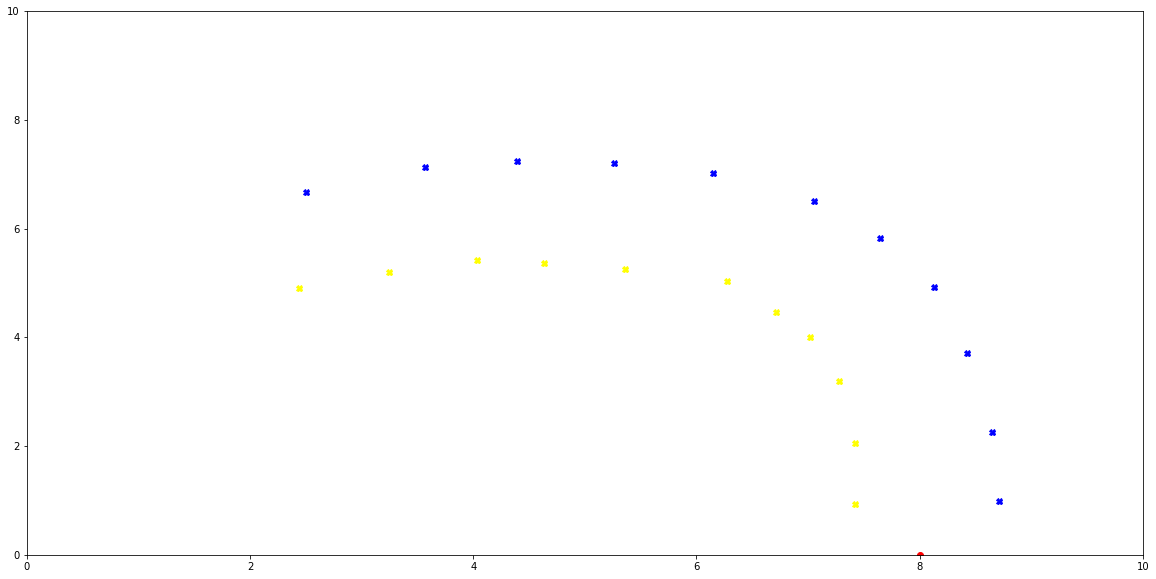

In [0]:
plt.figure(1, figsize=(20,10))
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.plot(b_cones[:,0], b_cones[:,1], "X", color="blue")
plt.plot(y_cones[:,0], y_cones[:,1], "X", color="yellow")
plt.plot(start[0], start[1], "o", color="red")


# Algorithm
## Initialize loop
1) find first blue (resp. yellow) cone
\begin{equation*}
    b_1 = argmin_{b \in B} ||s - b|| \\
    y_1 = argmin_{y \in Y} ||s - y|| 
\end{equation*}
where $B \ (\text{resp.} \ Y)$ is set of all detected blue cones (resp. yellow cones).

2) connect firsts cones by line and parametrize this line (line in 2D is $     f(x) = k\cdot x + c$) so

\begin{equation*}
    b_1[1] = k\cdot b_1[0] + c\\
    y_1[1] = k\cdot y_1[0] + c\\
    \text{that means}\\
    k = \frac{b_1[1]-y_1[1]}{b_1[0]-y_1[0]} \ \text{and} \ c = b_1[1] - k\cdot b_1[0]
\end{equation*}

We assume that in first loop it is also normal line to car's direction.

3) new start point is center between cones $\vec{s_0} = (s_{0}[0] ,s_{0}[1]) $
\begin{equation*}
    s_{0}[0] = \frac{b_{1}[0]-y_{1}[0]}{2},\\
    s_{0}[1] = \frac{b_{1}[1]-y_{1}[1]}{2}
\end{equation*}


## common loop
1) find first blue (resp. yellow) cone
\begin{equation*}
    b_2 = argmin_{b \in \hat{B}} ||s - b|| \\
    y_2 = argmin_{y \in \hat{Y}} ||s - y|| 
\end{equation*}
where $\hat{B} = \{b \in B \text{ and }  \& \ sign(k\cdot (b[1]-k\cdot b[0] - c))=1\} \ (\text{resp.} \ \hat{Y})$ is set of all detected blue cones (resp. yellow cones) in front of car.

2) find center (new start point) $\vec{s_1} = (s_{1}[0] ,s_{1}[1]) $
\begin{equation*}
    s_{1}[0] = \frac{b_{2}[0]-y_{2}[0]}{2}+ y_2[0], \\
    s_{1}[1] = \frac{b_{2}[1]-y_{2}[1]}{2}+ y_2[1]
\end{equation*}

3) find direction $\vec{s_1}-\vec{s_0}$
\begin{equation*}
    s_1[1] = k\cdot s_1[0] + c\\
    s_0[1] = k\cdot s_0[0] + c\\
    \text{that means}\\
    k = \frac{s_1[1]-s_0[1]}{s_1[0]-s_0[0]} \ \text{  and  } \ c = s_1[1] - k\cdot s_1[0]
\end{equation*}

4) find normal line to direction in point $\vec{s_1}$
\begin{equation*}
    k_{new} = -\frac{1}{k} \text{  and  } c_{new} = s_1[1] - k_{new}\cdot s_1[0],\\
    \text{normal line is than }\\
    f(x) = k_{new}\cdot x + c_{new}
\end{equation*}

## back to step one


# Algorithm

In [0]:
class PathPlanning(object):
    def __init__(self, start_point, clockwise=-1, debugging=False):
        """
        :params start_point: numpy.array with coordinates of starting point
        :param clockwise: direction in which we want to find path 
                            (if start_point[1]==0 => direction is -1 !!!)

        """
        self.sorted_blue_cones = []
        self.sorted_yellow_cones = []
        self.start_points = [start_point]
        self.clockwise = clockwise
        # parameters of normal line
        self.k = 0
        self.c = None
        self.k_past = 0
        self.debugging = debugging
        if self.debugging:
            self.ks = []
            self.cs = []
            self.direction_changes = []

    def reset(self, start_point, clockwise=-1):
        self.sorted_blue_cones = []
        self.sorted_yellow_cones = []
        self.start_points = [start_point]
        self.clockwise = clockwise
        # parameters of normal line
        self.k = None
        self.c = None
        self.k_past = 0
        if self.debugging:
            self.ks = []
            self.cs = []
            self.direction_changes = []

    def is_already_added(self, point):
        np.all(np.isin(point, self.sorted_yellow_cones))
        return (np.all(np.isin(point, self.sorted_yellow_cones)) or np.all(np.isin(point, self.sorted_blue_cones)))

    def points_above_normal(self, points):
        return points[np.sign((points[:,1] - self.k * points[:,0] - self.c))==np.sign(self.k)*self.clockwise]

    def find_closest_one(self, points):
        closest_index = np.argmin(np.linalg.norm(points-self.start_points[-1], axis=1))
        closest_cone = points[closest_index]
        return closest_cone

    def calculate_center(self, pointB, pointY):
        return np.array([(pointB[0]-pointY[0])/2 + pointY[0], (pointB[1]-pointY[1])/2 + pointY[1]])
    
    def return_stack(self, object_name):
        if object_name == "yellow cones":
            return np.vstack(self.sorted_yellow_cones)
        elif object_name == "blue cones":
            return np.vstack(self.sorted_blue_cones)
        elif object_name == "centers":
            return np.vstack(self.start_points)           

    def find_line_parameters(self, pointB, pointY, normal=True):
        k = (pointB[1]-pointY[1])/(pointB[0]-pointY[0])
        self.k_past = self.k
        self.k = -1/k if normal else k 
        c = pointB[1] - self.k*pointB[0]
        self.c = c
    
    def check_direction(self):
        if self.k != None and (self.k-self.k_past)==0:# and not(self.auxiliary_variable):
            self.clockwise = - self.clockwise

    def find_next_center(self, pointsB, pointsY, step=None, verbose=True):
        self.find_line_parameters(self.start_points[-1], self.start_points[-2])
        self.check_direction()

        if self.debugging:
            self.ks.append(self.k)
            self.cs.append(self.c)
            self.direction_changes.append(self.clockwise)
           

        B_hat = self.points_above_normal(pointsB)
        Y_hat = self.points_above_normal(pointsY)
        #set_trace()
        b = self.find_closest_one(B_hat)
        y = self.find_closest_one(Y_hat)

        if not self.is_already_added(b):
            self.sorted_blue_cones.append(b)
        if not self.is_already_added(y):
            self.sorted_yellow_cones.append(y)

        s = self.calculate_center(b, y)
        self.start_points.append(s)
        if verbose:
            if step != None:
                print("Step {} done!".format(step+1))
                #print(f"y={-1/self.k*b[0]+self.c},k={self.c}, b={self.c}")
            else:
                print("Step done!")

    def find_path(self, B, Y, n_steps, verbose=True):
        if n_steps < 1:
            raise ValueError("Number of steps must be positive!!")
        """
            B is set of all blue cones
            Y is set of all yellow cones
        """
        # initializing loop
        # step 1)
        b_0 = self.find_closest_one(B)
        y_0 = self.find_closest_one(Y)
        self.sorted_blue_cones.append(b_0)
        self.sorted_yellow_cones.append(y_0)

        s_1 = self.calculate_center(b_0, y_0)
        self.start_points.append(s_1)
        if verbose:
            print("Step 1 done!")

        # step 2)
        if n_steps > 1:
            self.find_line_parameters(b_0, y_0, normal=False) # special case of separate line for 2nd step
            B_hat = self.points_above_normal(B)
            Y_hat = self.points_above_normal(Y)
            #set_trace()
            b_1 = self.find_closest_one(B_hat)
            y_1 = self.find_closest_one(Y_hat)
            self.sorted_blue_cones.append(b_1)
            self.sorted_yellow_cones.append(y_1)

            s_2 = self.calculate_center(b_1, y_1)
            self.start_points.append(s_2)
            if verbose:
                print("Step 2 done!")

        #every other step
        if n_steps >2:
            for step in range(n_steps-2):
                try:
                    self.find_next_center(B, Y, step+2, verbose=verbose)
                    if self.debugging:
                        print(f"k={self.k}, c={self.c}, clockwise={self.clockwise}")
                except ValueError as err:
                    # catching specific error
                    if str(err) == "attempt to get argmin of an empty sequence":
                        warnings.warn("Too many iteration!")
                        break
                    else: 
                        raise ValueError(str(err))

# testy

In [0]:
path = PathPlanning(np.array([8,0]), clockwise=-1)

In [27]:
vars(path)

{'c': None,
 'clockwise': -1,
 'debugging': False,
 'k': 0,
 'k_past': 0,
 'sorted_blue_cones': [],
 'sorted_yellow_cones': [],
 'start_points': [array([8, 0])]}

In [28]:
path.find_path(B=b_cones, Y=y_cones, n_steps=1, verbose=True)

Step 1 done!


In [29]:
vars(path)

{'c': None,
 'clockwise': -1,
 'debugging': False,
 'k': 0,
 'k_past': 0,
 'sorted_blue_cones': [array([8.70967742, 0.98951258])],
 'sorted_yellow_cones': [array([7.41935484, 0.93517361])],
 'start_points': [array([8, 0]), array([8.06451613, 0.9623431 ])]}

In [0]:
path.reset(np.array([8,0]), clockwise=1)

In [31]:
vars(path)

{'c': None,
 'clockwise': 1,
 'debugging': False,
 'k': None,
 'k_past': 0,
 'sorted_blue_cones': [],
 'sorted_yellow_cones': [],
 'start_points': [array([8, 0])]}

In [32]:
path.find_path(B=b_cones, Y=y_cones, n_steps=2, verbose=True)

Step 1 done!
Step 2 done!


In [33]:
vars(path)

{'c': 0.6227245557789521,
 'clockwise': 1,
 'debugging': False,
 'k': 0.04211269901646438,
 'k_past': None,
 'sorted_blue_cones': [array([8.70967742, 0.98951258]),
  array([8.64919355, 2.26647829])],
 'sorted_yellow_cones': [array([7.41935484, 0.93517361]),
  array([7.41935484, 2.04912243])],
 'start_points': [array([8, 0]),
  array([8.06451613, 0.9623431 ]),
  array([8.03427419, 2.15780036])]}

In [34]:
starts = np.vstack(path.start_points)
starts

array([[8.        , 0.        ],
       [8.06451613, 0.9623431 ],
       [8.03427419, 2.15780036]])

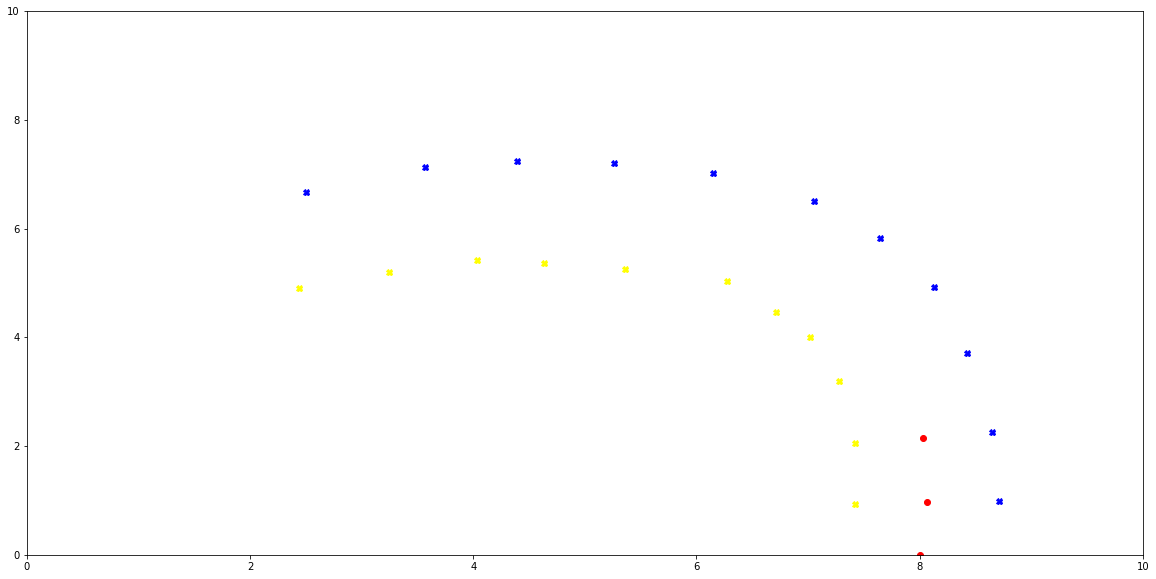

In [35]:
plt.figure(1, figsize=(20,10))
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.plot(b_cones[:,0], b_cones[:,1], "X", color="blue")
plt.plot(y_cones[:,0], y_cones[:,1], "X", color="yellow")
plt.plot(starts[:,0],starts[:,1], "o", color="red")
#axis = np.linspace(0, 10)
#plt.plot(axis, k*axis+c, color="green")
#plt.plot(new_start[0], new_start[1], "o", color="red")

In [0]:
path.reset(np.array([8,0]), clockwise=1)

In [37]:
path.find_path(B=b_cones, Y=y_cones, n_steps=20, verbose=True)

Step 1 done!
Step 2 done!
Step 3 done!
Step 4 done!
Step 5 done!
Step 6 done!
Step 7 done!
Step 8 done!
Step 9 done!
Step 10 done!
Step 11 done!
Step 12 done!
Step 13 done!
Step 14 done!
Step 15 done!
Step 16 done!
Step 17 done!
Step 18 done!
Step 19 done!
Step 20 done!


In [0]:
starts = path.return_stack(object_name="centers")
Y_cones = path.return_stack(object_name="yellow cones")
B_cones = path.return_stack(object_name="blue cones")

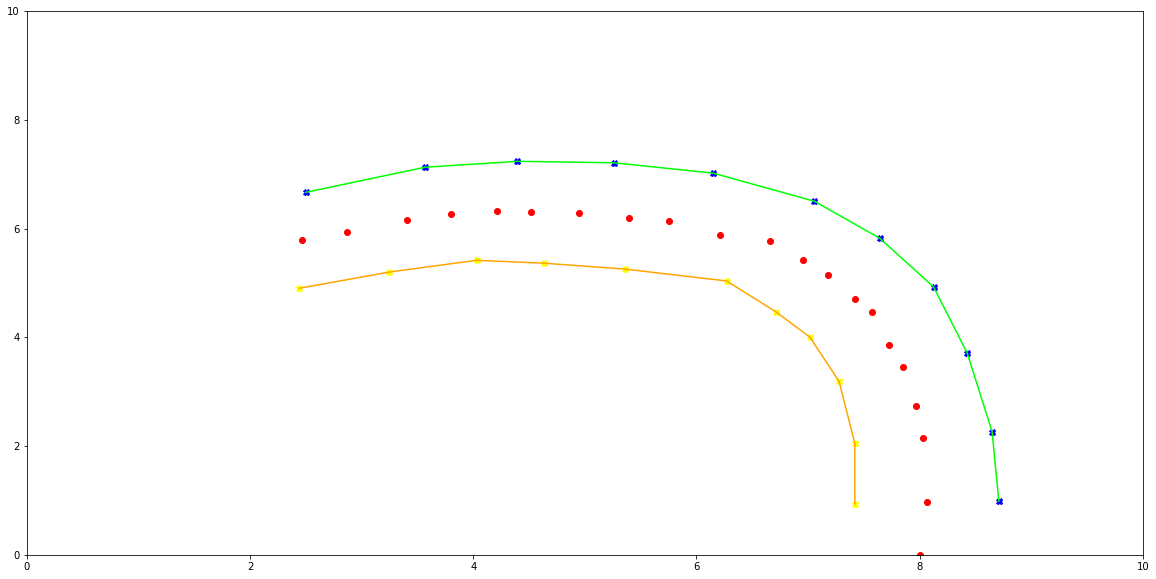

In [39]:
plt.figure(1, figsize=(20,10))
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.plot(b_cones[:,0], b_cones[:,1], "X", color="blue")
plt.plot(y_cones[:,0], y_cones[:,1], "X", color="yellow")
plt.plot(B_cones[:,0], B_cones[:,1], color="lime")
plt.plot(Y_cones[:,0], Y_cones[:,1], color="orange")
plt.plot(starts[:,0],starts[:,1], "o", color="red")

# track-generator test

In [0]:
inner = np.load("Path-Planning/data/inner.npy")
outer = np.load("Path-Planning/data/outer.npy")

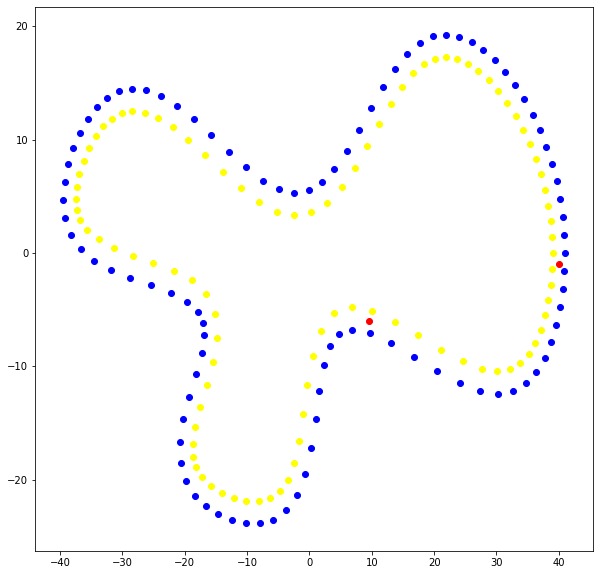

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(inner[:, 0], inner[:, 1], c="yellow", lw=1)
plt.scatter(outer[:, 0], outer[:, 1], c="blue",lw=1)
plt.scatter([9.5,40], [-6,-1] ,c="red")
#plt.axis('equal')
plt.show()

In [0]:
path = PathPlanning(np.array([40,-1]), clockwise=-1, debugging=True)#[9.8,-6]

In [43]:
path.find_path(B=outer, Y=inner, n_steps=190, verbose=False)

k=-0.05487552029776727, c=2.195020811910691, clockwise=-1
k=0.05218947710976341, c=-1.384308940398928, clockwise=-1
k=0.05218947710976341, c=-2.0875790843905366, clockwise=1
k=0.052540461803892824, c=-1.293781930762244, clockwise=1
k=0.052189477109753274, c=-0.5764872552256479, clockwise=1
k=0.1573745337738818, c=-4.058571443817893, clockwise=1
k=0.1576964370654874, c=-3.2501205367600328, clockwise=1
k=0.26381851026440106, c=-6.716907095825339, clockwise=1
k=0.26411063270569907, c=-5.880148741490434, clockwise=1
k=0.37240401760303554, c=-9.348806572629316, clockwise=1
k=0.3726680632815663, c=-8.469843139441254, clockwise=1
k=0.48460063051217334, c=-11.96577427190034, clockwise=1
k=0.48481165413559374, c=-11.030628427458062, clockwise=1
k=0.6007939863900319, c=-14.531130722998801, clockwise=1
k=0.6010252594694329, c=-13.525869637866975, clockwise=1
k=0.7235590446670244, c=-17.08598792554682, clockwise=1
k=0.7237870804339817, c=-15.99447607127249, clockwise=1
k=0.8553106794565137, c=-19.

In [0]:
starts = path.return_stack(object_name="centers")
Y_cones = path.return_stack(object_name="yellow cones")
B_cones = path.return_stack(object_name="blue cones")

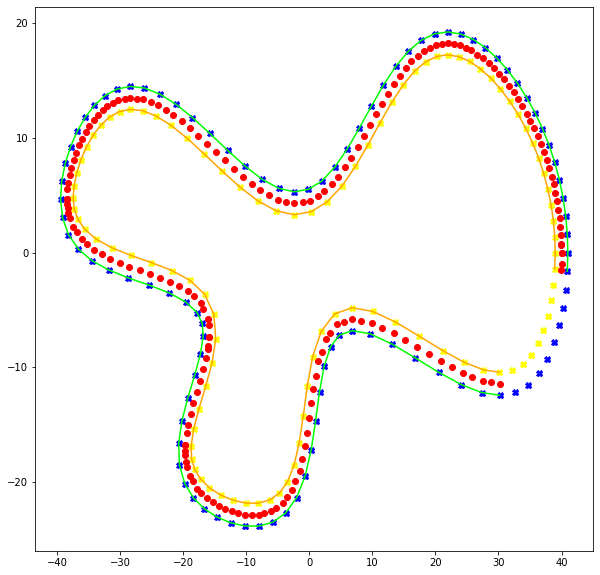

In [45]:
plt.figure(1, figsize=(10,10))
plt.plot(outer[:,0], outer[:,1], "X", color="blue")
plt.plot(inner[:,0], inner[:,1], "X", color="yellow")
plt.plot(B_cones[:,0], B_cones[:,1], color="lime")
plt.plot(Y_cones[:,0], Y_cones[:,1], color="orange")
plt.plot(starts[:,0],starts[:,1], "o", color="red")

In [0]:
path1 = PathPlanning(np.array([9.8,-6]), clockwise=1, debugging=False)

In [0]:
path1.find_path(B=outer, Y=inner, n_steps=206, verbose=False)

In [0]:
starts1 = path1.return_stack(object_name="centers")
Y_cones1 = path1.return_stack(object_name="yellow cones")
B_cones1 = path1.return_stack(object_name="blue cones")

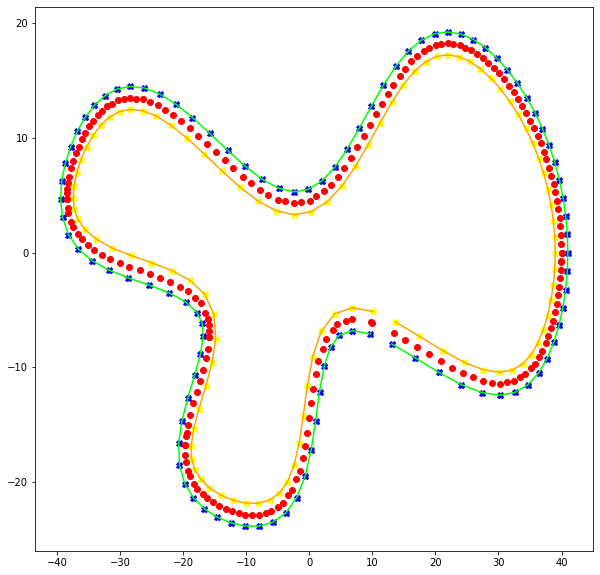

In [54]:
plt.figure(1, figsize=(10,10))
plt.plot(outer[:,0], outer[:,1], "X", color="blue")
plt.plot(inner[:,0], inner[:,1], "X", color="yellow")
plt.plot(B_cones1[:,0], B_cones1[:,1], color="lime")
plt.plot(Y_cones1[:,0], Y_cones1[:,1], color="orange")
plt.plot(starts1[:,0],starts1[:,1], "o", color="red")

# animace

0, k=-0.05487552029776727, c=2.195020811910691


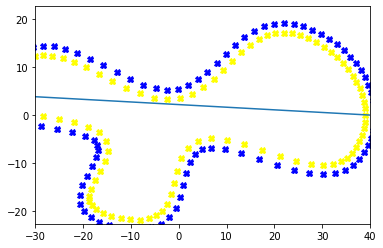

1, k=0.05218947710976341, c=-1.384308940398928


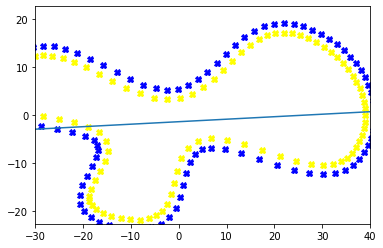

2, k=0.05218947710976341, c=-2.0875790843905366


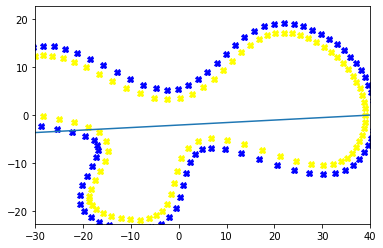

3, k=0.052540461803892824, c=-1.293781930762244


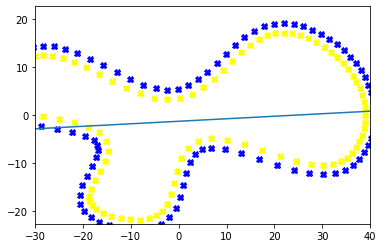

4, k=0.052189477109753274, c=-0.5764872552256479


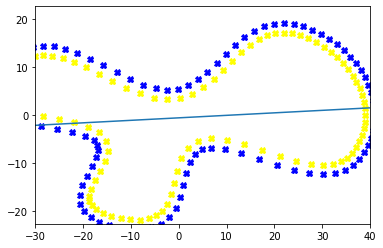

5, k=0.1573745337738818, c=-4.058571443817893


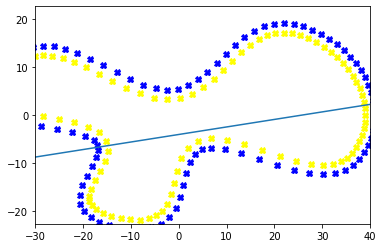

6, k=0.1576964370654874, c=-3.2501205367600328


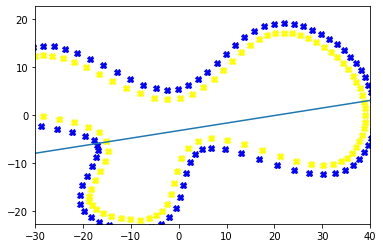

7, k=0.26381851026440106, c=-6.716907095825339


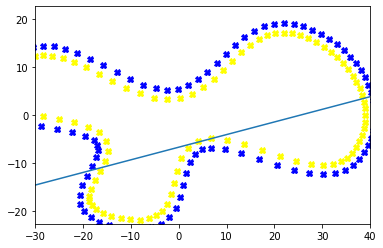

8, k=0.26411063270569907, c=-5.880148741490434


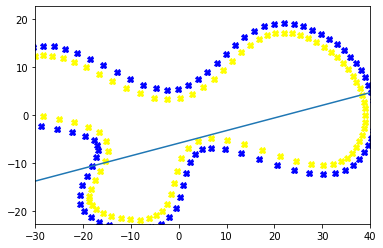

9, k=0.37240401760303554, c=-9.348806572629316


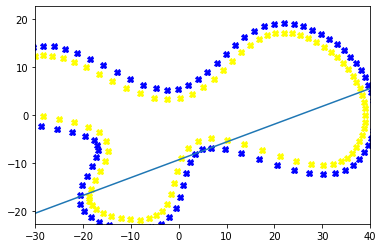

10, k=0.3726680632815663, c=-8.469843139441254


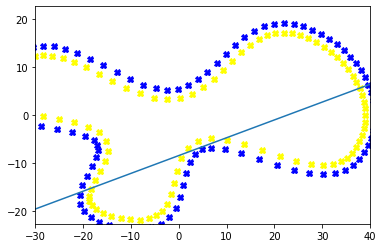

11, k=0.48460063051217334, c=-11.96577427190034


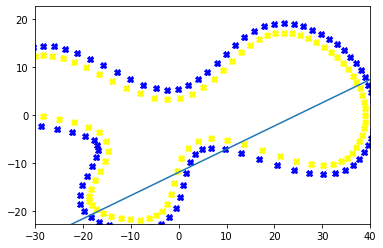

12, k=0.48481165413559374, c=-11.030628427458062


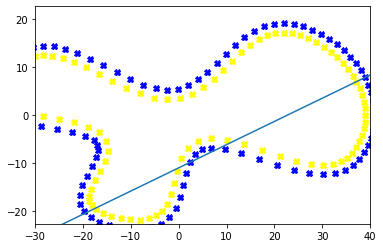

13, k=0.6007939863900319, c=-14.531130722998801


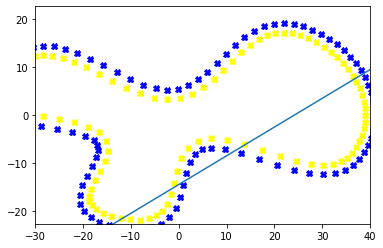

14, k=0.6010252594694329, c=-13.525869637866975


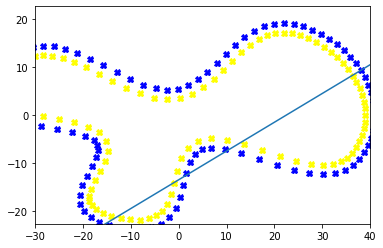

15, k=0.7235590446670244, c=-17.08598792554682


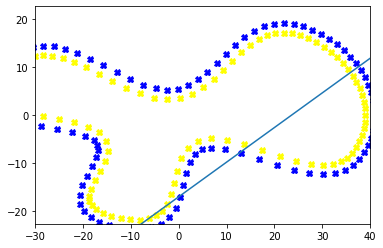

16, k=0.7237870804339817, c=-15.99447607127249


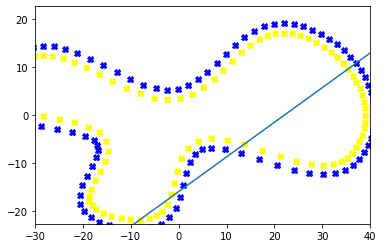

17, k=0.8553106794565137, c=-19.656503277412387


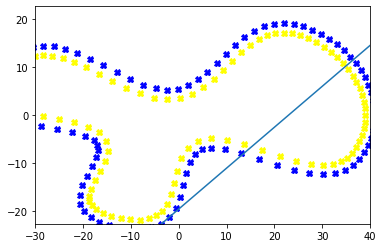

18, k=0.8555508992810883, c=-18.461841522151367


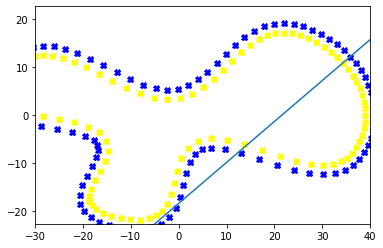

19, k=1.0003752160729957, c=-22.321560089423087


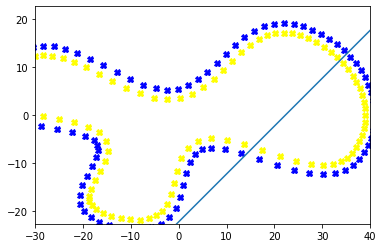

20, k=1.0006521693462027, c=-21.004411115356564


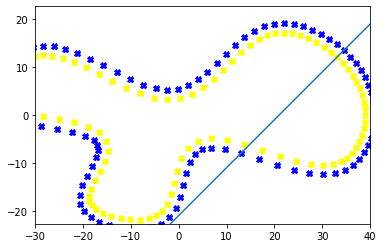

21, k=1.166264181183909, c=-25.24207896147294


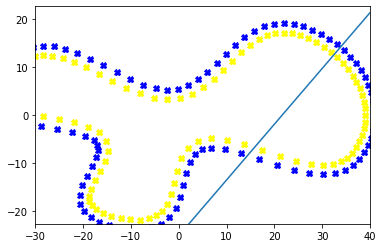

22, k=1.1666214992967858, c=-23.7783837481311


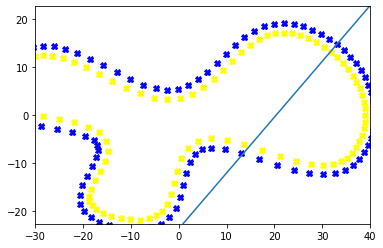

23, k=1.3667943335373525, c=-28.73444682752492


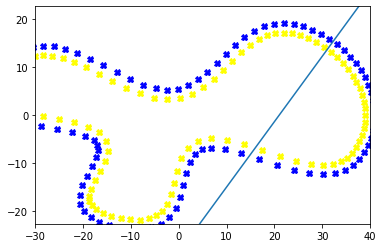

24, k=1.3673192249583836, c=-27.09042136344258


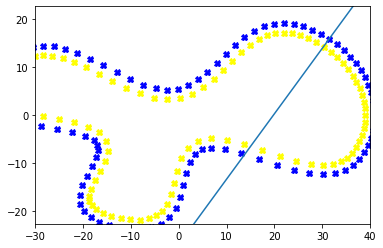

25, k=1.6291636004528673, c=-33.42989798699122


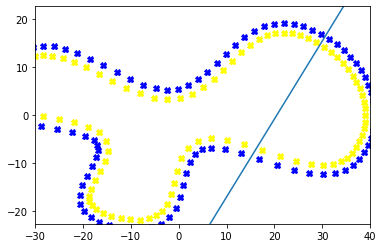

26, k=1.6300530753796045, c=-31.55068787465011


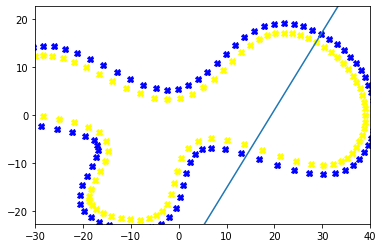

27, k=2.0126719970317235, c=-40.68725413303463


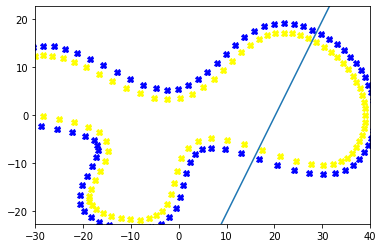

28, k=2.0144369836683778, c=-38.46905183233332


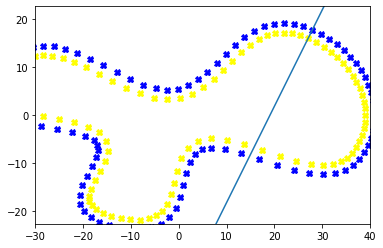

29, k=2.671001234956469, c=-53.958359423625275


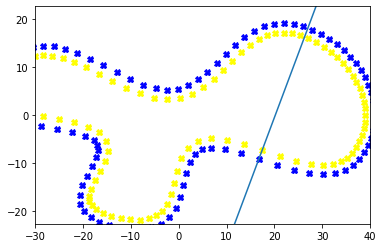

30, k=2.6752435870669102, c=-51.167902531392876


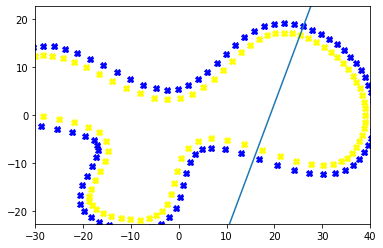

31, k=4.1545661278328465, c=-85.41780484164744


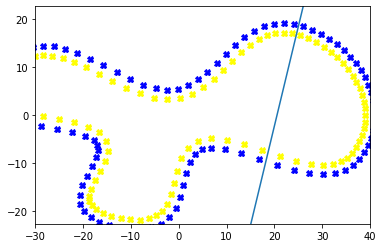

32, k=4.1684541079340125, c=-81.37686074139012


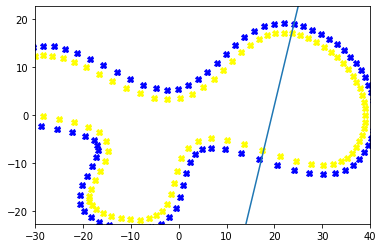

33, k=10.987905503756295, c=-234.44712740270595


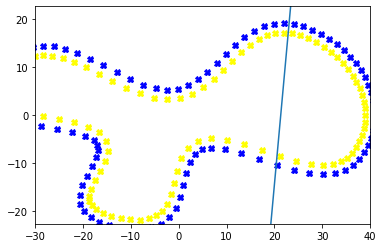

34, k=11.10822086154084, c=-225.69377180021198


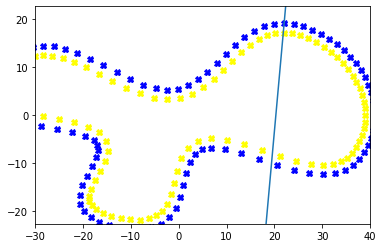

35, k=-12.881943774172354, c=289.8672313239561


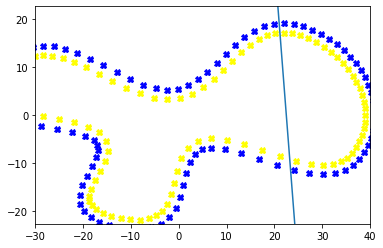

36, k=-12.721507264652336, c=273.0627130143616


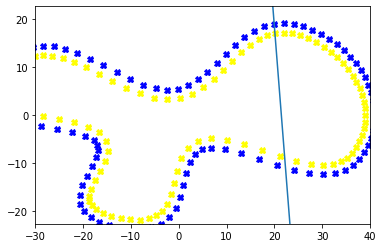

37, k=-3.7765458373262724, c=90.26347251863113


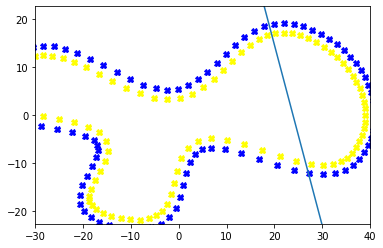

38, k=-3.7671234683566266, c=85.85142789858533


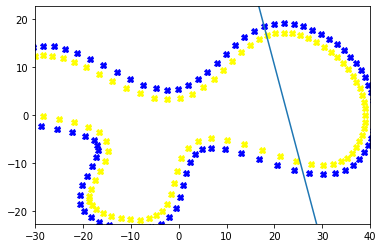

39, k=-2.152928998237112, c=54.29821846060178


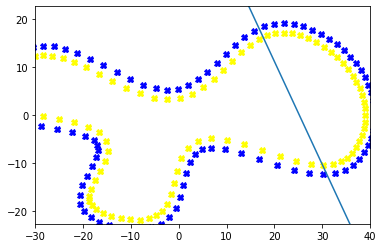

40, k=-2.152039491928772, c=51.58360048913056


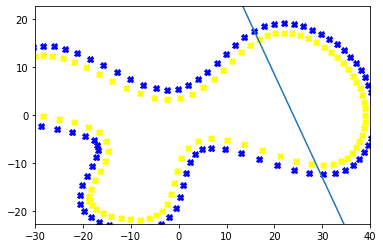

41, k=-1.5083690753110108, c=39.21302287379336


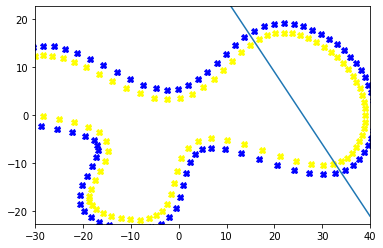

42, k=-1.5086925657247383, c=37.0384009916805


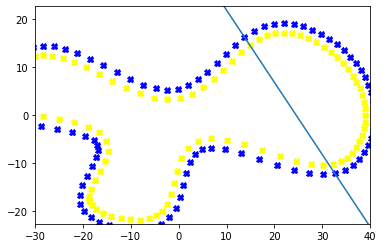

43, k=-1.1935379622728342, c=30.68476868240373


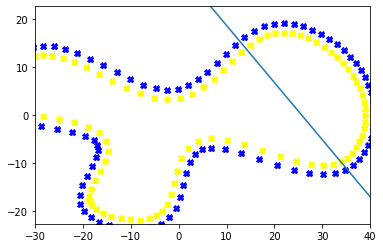

44, k=-1.1938936106275848, c=28.704828732951217


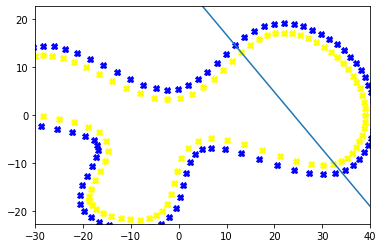

45, k=-1.0414267936011903, c=24.95408286999111


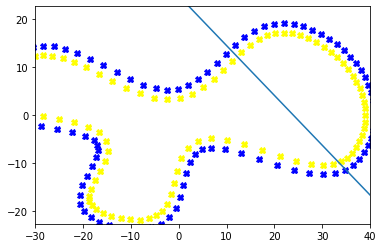

46, k=-1.041633990304245, c=23.035831726232544


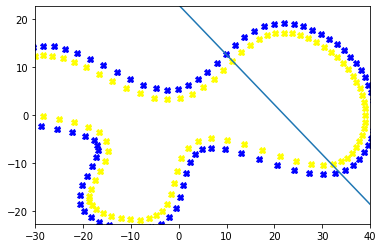

47, k=-0.9980192984456142, c=20.660142441728496


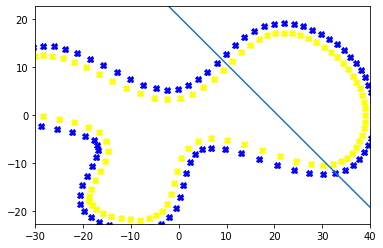

48, k=-0.9979955581897714, c=18.74909516278042


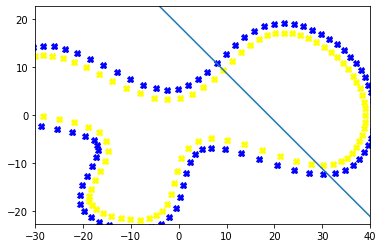

49, k=-1.0554909327209139, c=17.31157017213817


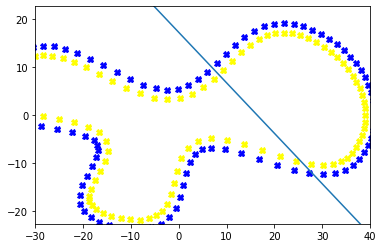

50, k=-1.0560236841451938, c=15.300300266583047


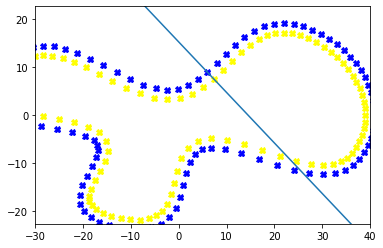

51, k=-1.2486831674661907, c=14.559814979995902


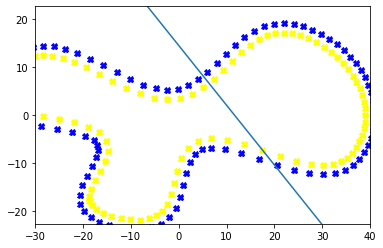

52, k=-1.250573012853886, c=12.362541102354461


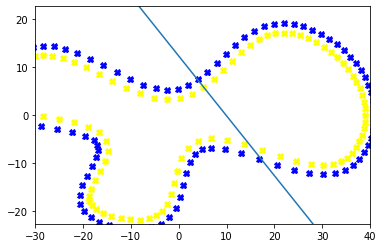

53, k=-1.7039888074313012, c=12.114181693696302


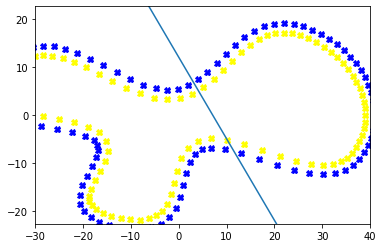

54, k=-1.7094861931287306, c=9.449336447233236


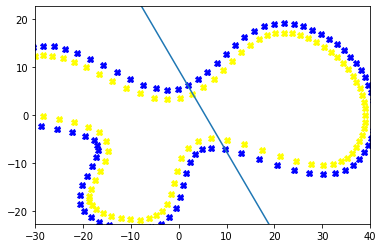

55, k=-2.937961774835371, c=8.926437488099308


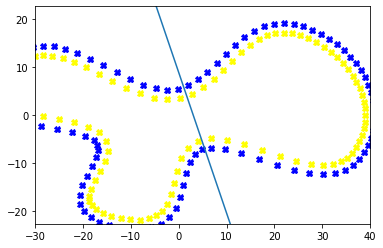

56, k=-2.9528015750292735, c=4.7609725460564905


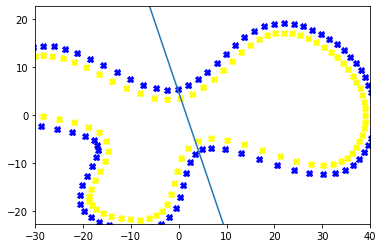

57, k=-10.483473706115538, c=-6.631583929209484


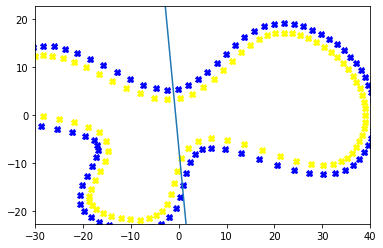

58, k=-10.555921780517018, c=-21.14575625059603


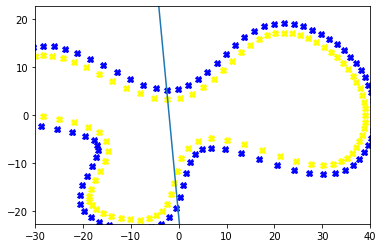

59, k=8.18969274991127, c=34.18435887731682


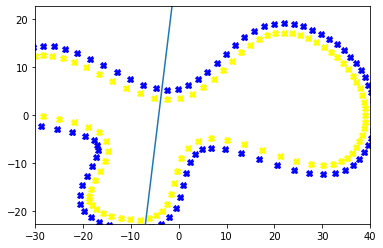

60, k=8.19633367938775, c=45.91826379724589


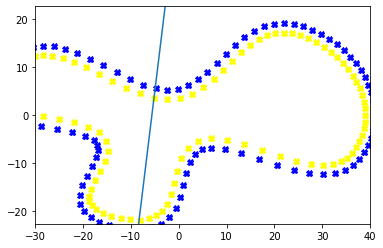

61, k=3.3684756735310377, c=26.381766751050833


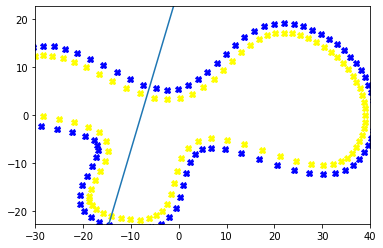

62, k=3.3710680865772606, c=31.662349048955036


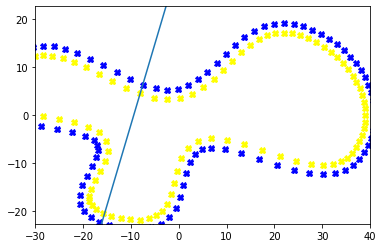

63, k=2.3676967453312425, c=27.676751933738416


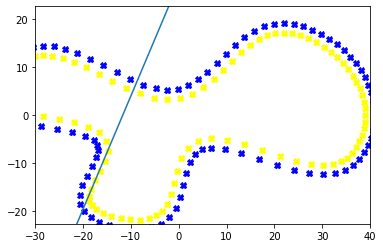

64, k=2.3685604634147395, c=31.717654038940807


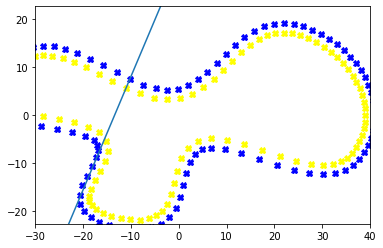

65, k=2.0111009692577797, c=31.446441332608774


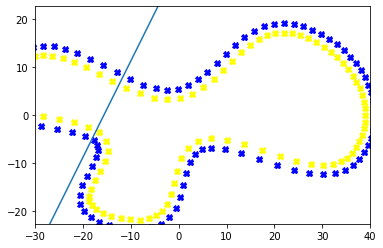

66, k=2.0114124738053767, c=35.05216224157495


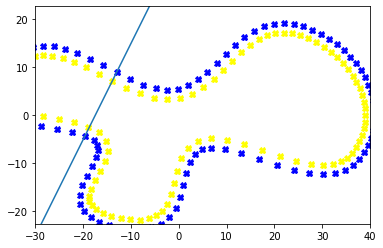

67, k=1.9114312932462871, c=37.126351163862246


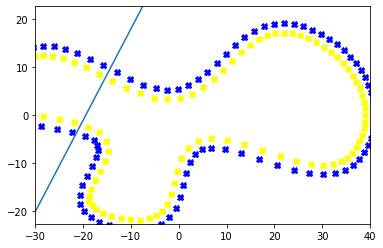

68, k=1.9114399422896011, c=40.54496661012761


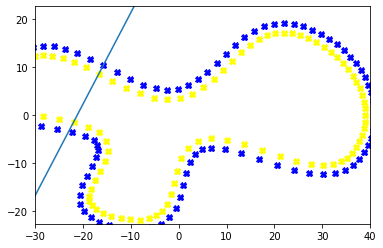

69, k=1.986185859905659, c=45.116262604537454


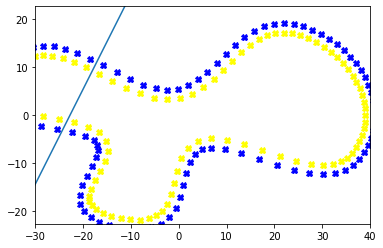

70, k=1.9866110918056024, c=48.55804786770619


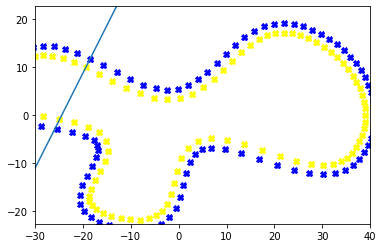

71, k=2.260798165025869, c=57.19411509277609


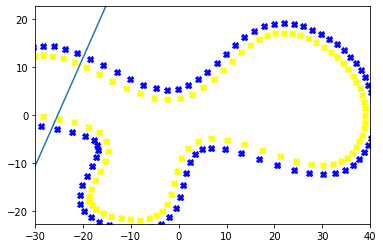

72, k=2.262290343866145, c=60.83328171111306


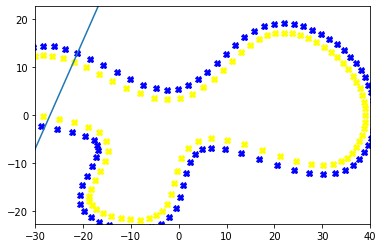

73, k=2.901670868423668, c=78.44343953052754


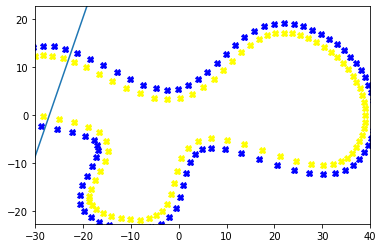

74, k=2.9064755272585643, c=82.6978368477327


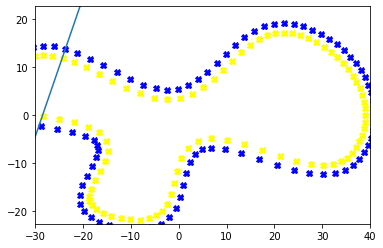

75, k=4.631511061831128, c=129.32488251865323


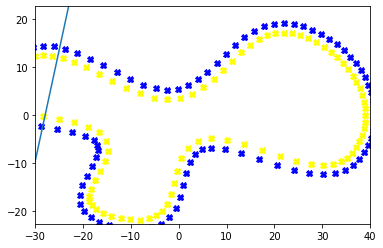

76, k=4.650957573483768, c=135.68088079294554


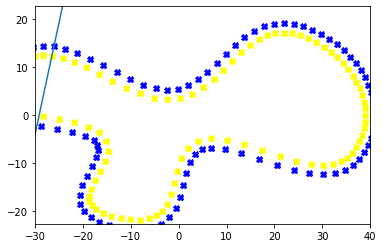

77, k=16.12624405415492, c=453.03790068527894


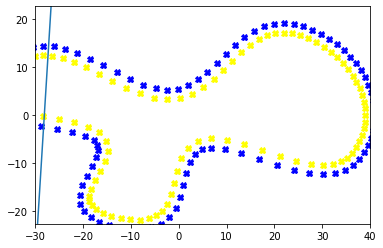

78, k=16.43269491910464, c=479.99894482204223


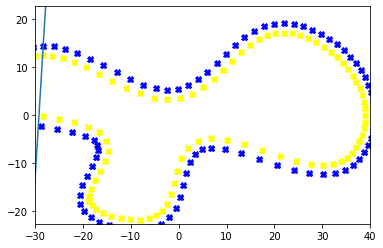

79, k=-8.976435352719008, c=-249.1582758517376


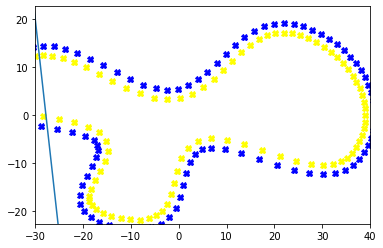

80, k=-8.882513428381738, c=-255.77274156999397


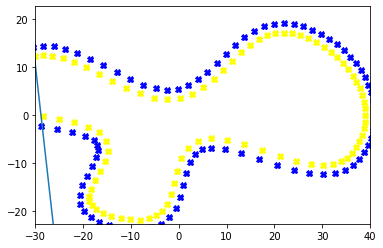

81, k=-3.338128285602526, c=-90.6334337760137


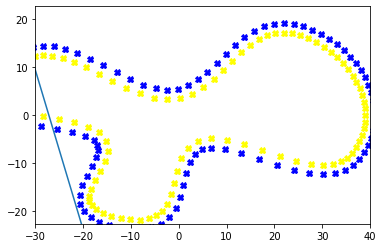

82, k=-3.326957037554885, c=-93.70552346522837


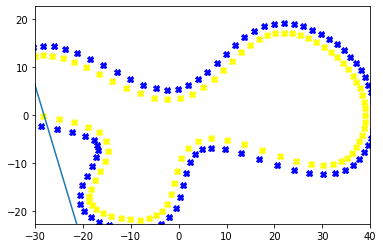

83, k=-1.997807985787798, c=-52.89432862662818


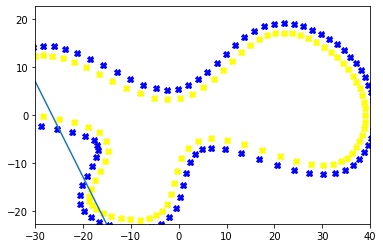

84, k=-1.9946052325419061, c=-54.88688441310008


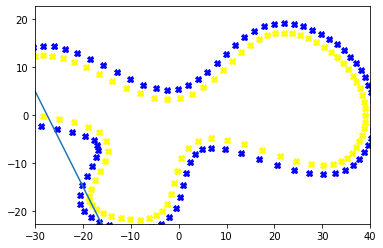

85, k=-1.3947892075187653, c=-36.06864312328027


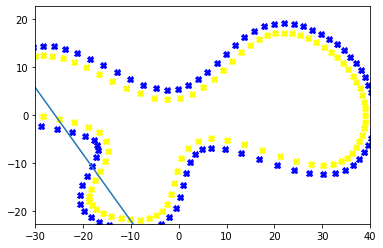

86, k=-1.3932791152111947, c=-37.57200626262012


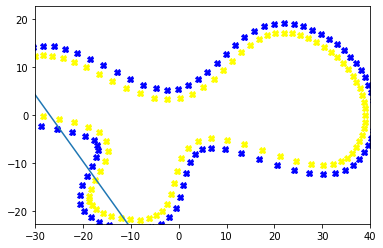

87, k=-1.040680144590411, c=-26.338939376141962


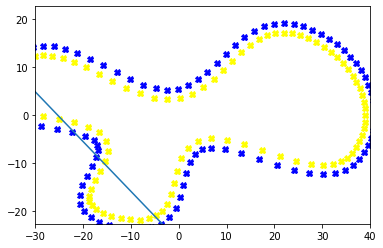

88, k=-1.0395382840826892, c=-27.567016285084122


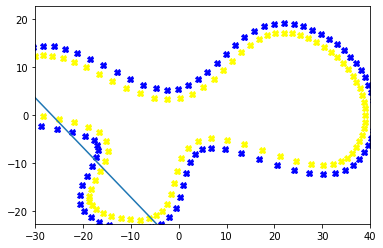

89, k=-0.7901735511825034, c=-19.48788734847085


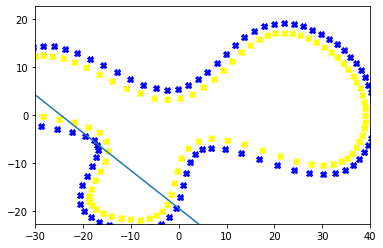

90, k=-0.7889048495437407, c=-20.529458962723922


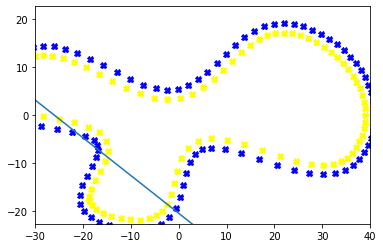

91, k=-0.5796968473284304, c=-13.561858589928452


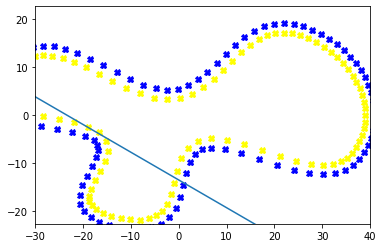

92, k=-0.5778121835918814, c=-14.449199730116973


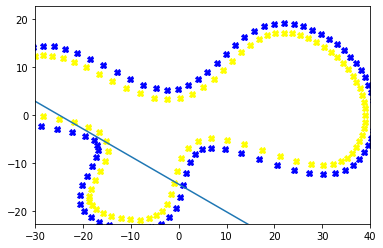

93, k=-0.3703050152892658, c=-7.260889520080317


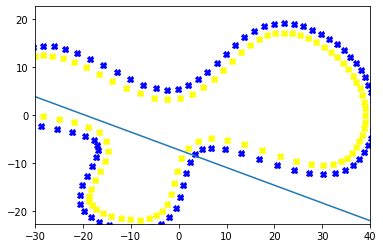

94, k=-0.3668702926137308, c=-7.9916329761824985


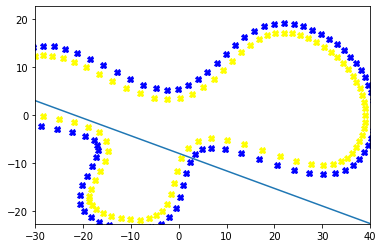

95, k=-0.12845127520907404, c=0.5968304086116669


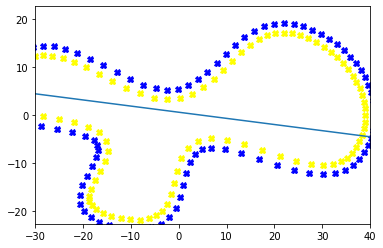

96, k=-0.12197576449904508, c=0.036372334906271675


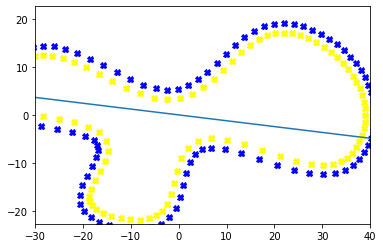

97, k=0.1856877287935653, c=11.379896102411646


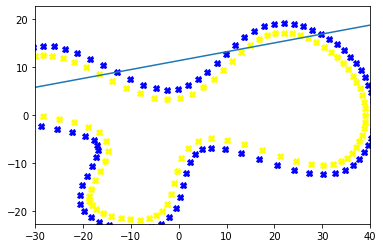

98, k=0.1856877287935653, c=11.864071488825163


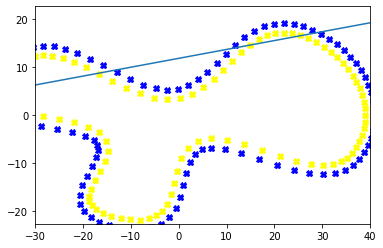

99, k=0.1939070251638829, c=11.338548075217169


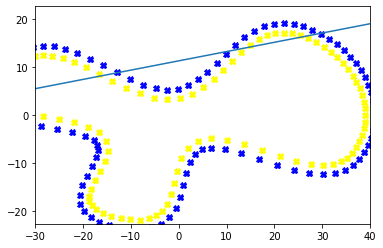

100, k=0.1856877287935653, c=10.539685732422399


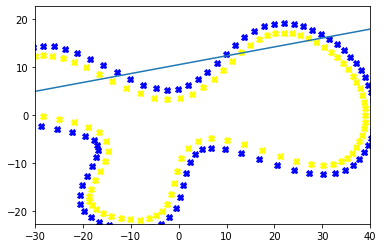

101, k=0.6263924151626029, c=26.759082903763858


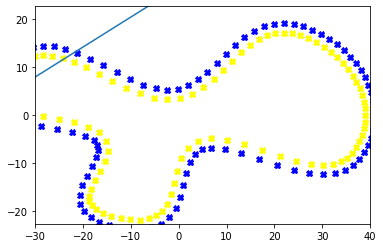

102, k=0.627473115911983, c=25.75433083308105


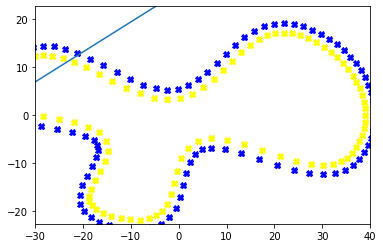

103, k=1.2556215183777069, c=48.13663619205477


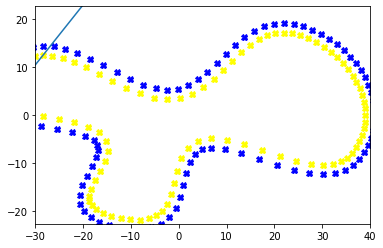

104, k=1.247876396823162, c=46.256416866956805


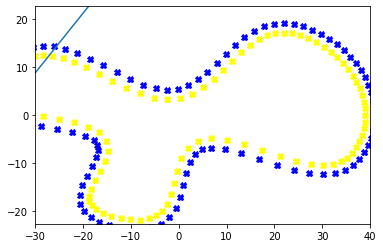

105, k=2.1251426414537216, c=75.60037881940916


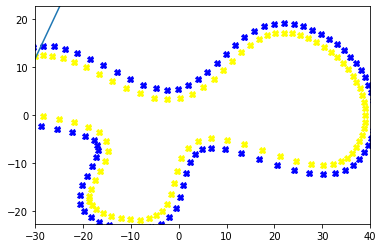

106, k=2.118810790654272, c=72.60803969532544


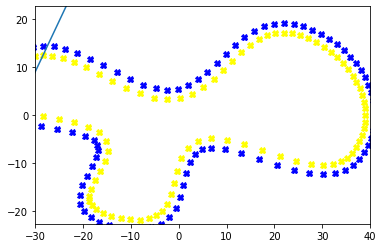

107, k=3.2804990634209497, c=107.8411469387698


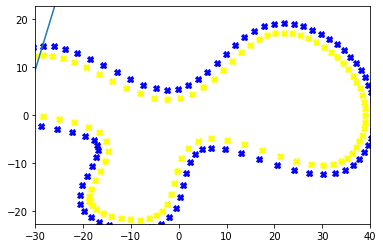

108, k=3.27635029791317, c=102.90790111505548


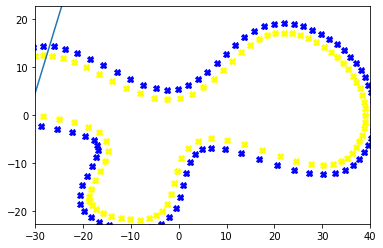

109, k=4.514570272467145, c=134.8888920723384


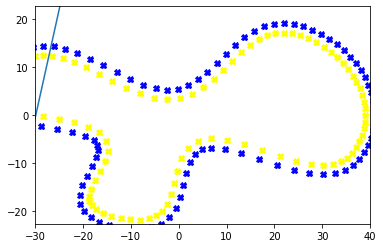

110, k=4.512268761995856, c=127.47780864597642


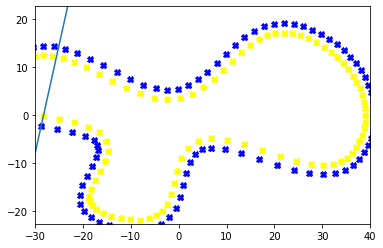

111, k=5.197160177877492, c=138.15358597618248


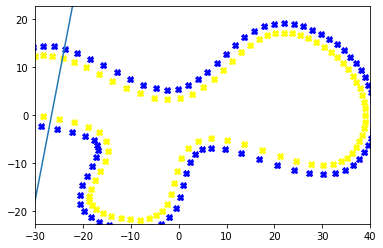

112, k=5.196907937704153, c=129.27012472839283


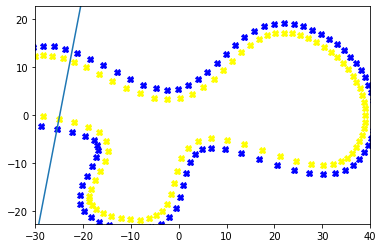

113, k=4.7050633862454285, c=109.09358461258779


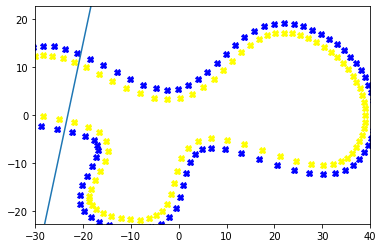

114, k=4.7005933890649025, c=100.99420991114249


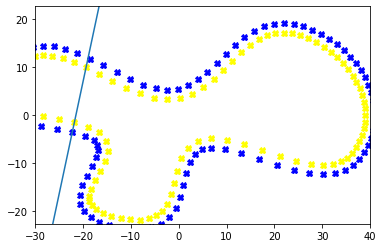

115, k=3.348570447427347, c=66.38556213274927


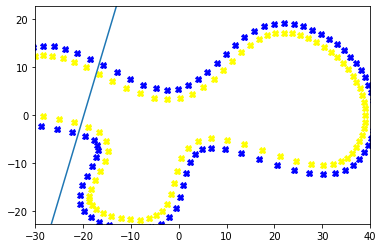

116, k=3.3334577759536486, c=60.8085780671582


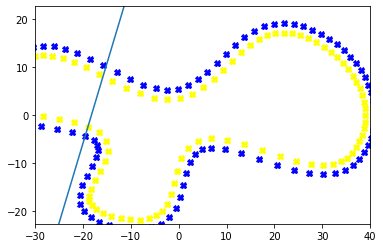

117, k=1.9419655305814216, c=31.81608386415725


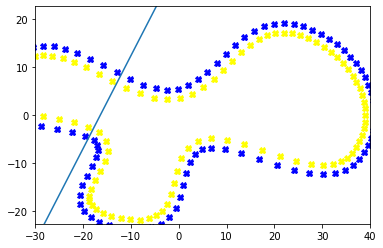

118, k=1.9067893062485943, c=28.387681270980217


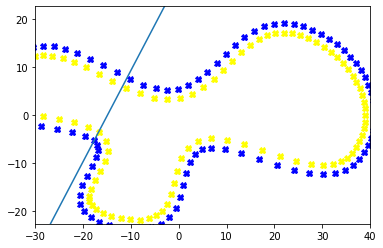

119, k=0.876341423023246, c=9.825155951877608


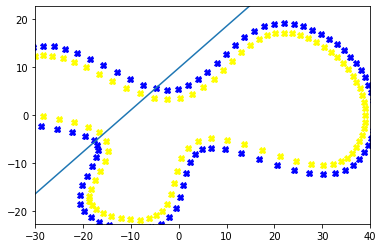

120, k=0.8344492811082227, c=7.645997129974455


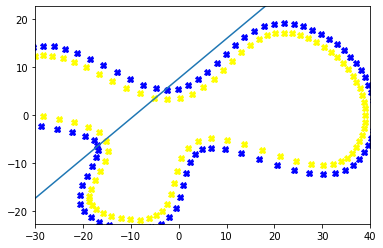

121, k=0.14091646174037256, c=-4.056975433207613


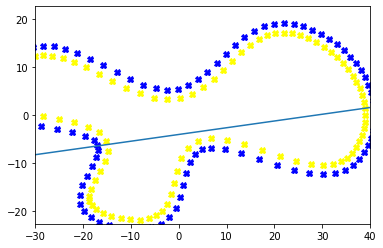

122, k=0.14517882777982283, c=-5.0759588821052075


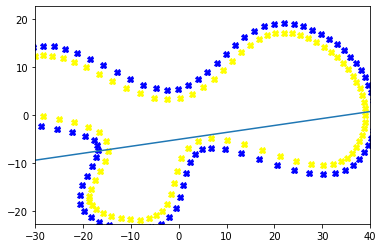

123, k=-0.281559394344467, c=-12.67287951372247


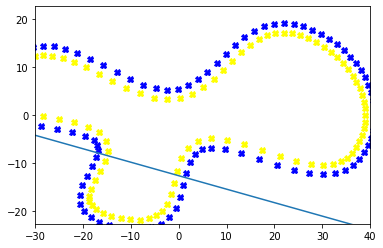

124, k=-0.281559394344467, c=-11.8306441355281


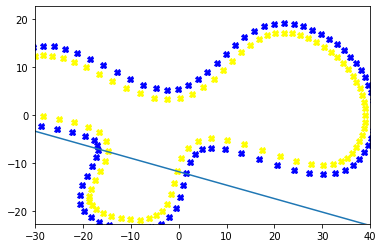

125, k=-0.2761723193512648, c=-12.880465636959956


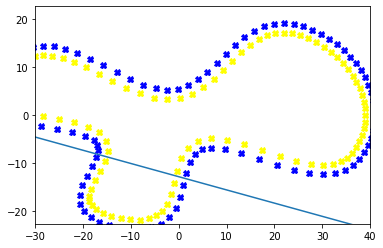

126, k=-0.28155939434446725, c=-13.809540150507654


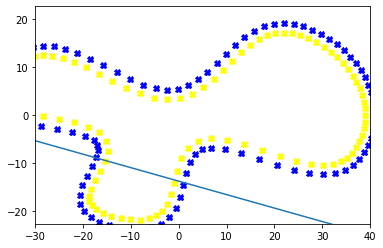

127, k=-0.4938266144802928, c=-18.43783929709211


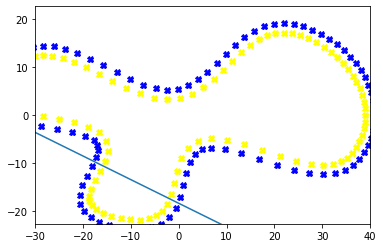

128, k=-0.4927007406599094, c=-19.692497618304863


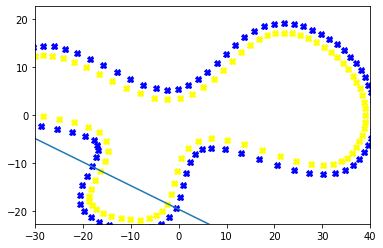

129, k=-0.5485172957886525, c=-21.947361749820836


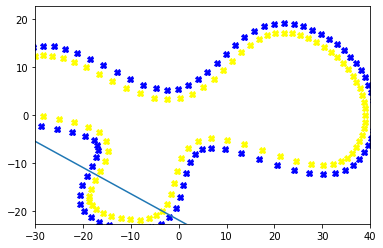

130, k=-0.5486641621463124, c=-23.222933973064702


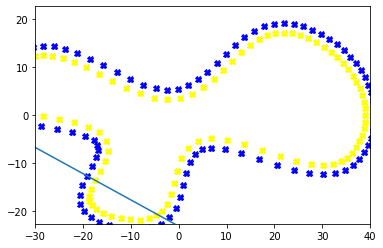

131, k=-0.47054988504510104, c=-22.866786815281685


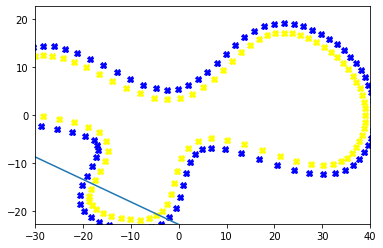

132, k=-0.46855256508166504, c=-24.04243437199262


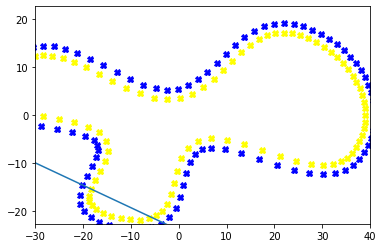

133, k=-0.269527199543267, c=-20.99385200502359


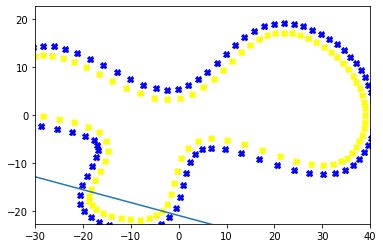

134, k=-0.26251924211711347, c=-21.904346038153626


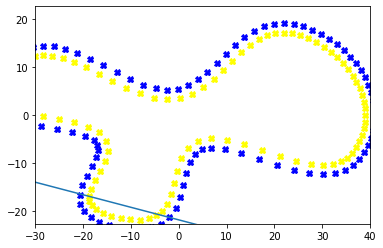

135, k=0.05340652073373239, c=-16.2330235909792


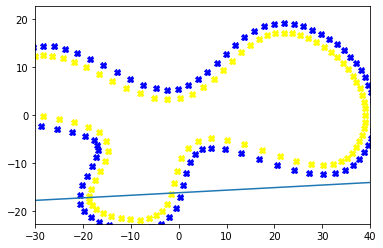

136, k=0.05340652073373239, c=-15.67359306766176


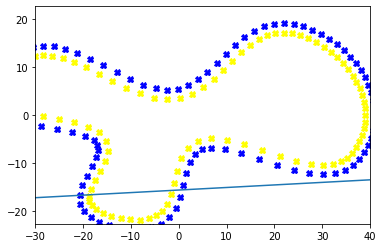

137, k=0.06592791411280578, c=-16.372620849192163


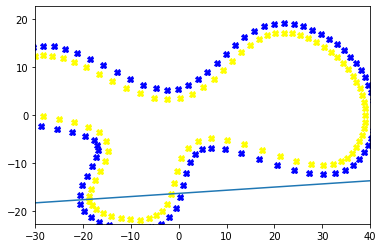

138, k=0.05340652073373239, c=-17.17822333838817


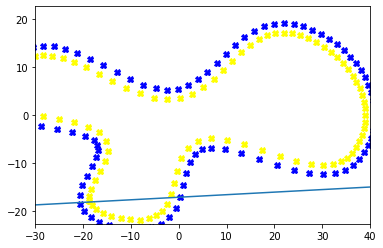

139, k=0.5149448815903498, c=-8.70021689647452


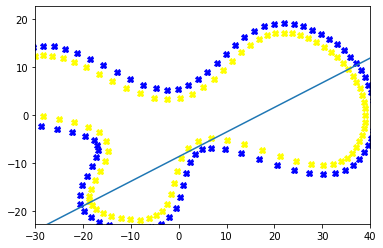

140, k=0.5172339677953945, c=-9.689908634828289


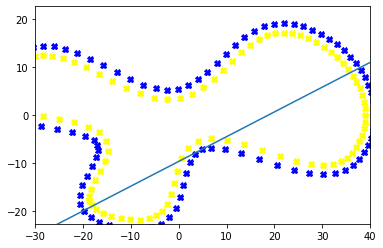

141, k=1.1069918868011235, c=0.5412176069975558


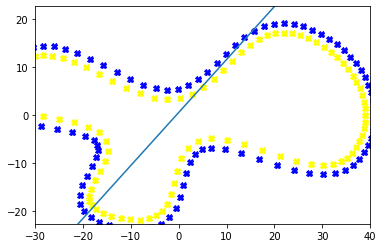

142, k=1.1016638047780476, c=-0.9479207437910873


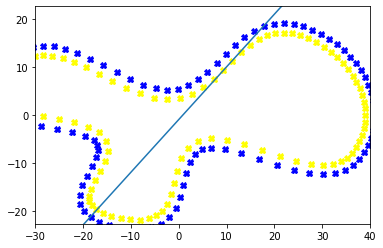

143, k=1.844898797586422, c=10.596956574045322


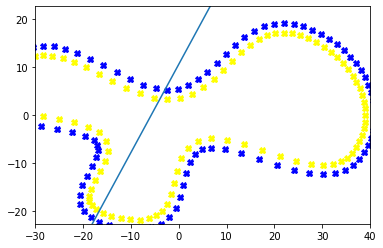

144, k=1.8411462052957253, c=8.454476202959945


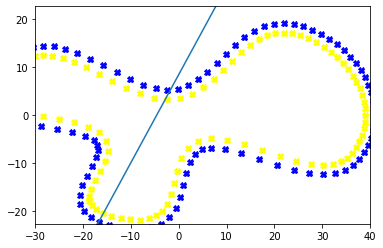

145, k=2.811179209310283, c=21.41617379170316


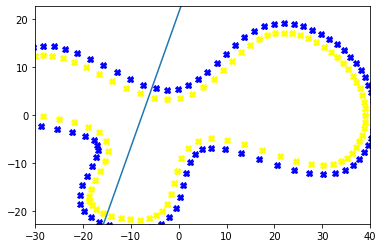

146, k=2.810108171134048, c=18.240600213646186


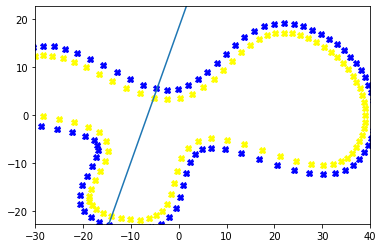

147, k=4.317750360086546, c=35.42492362295134


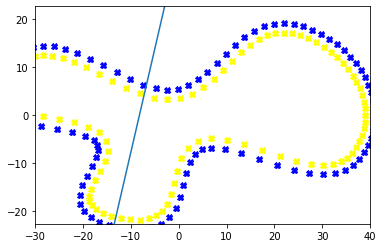

148, k=4.320693527904499, c=30.54602713076203


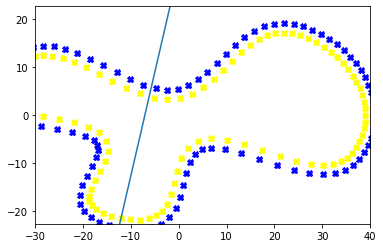

149, k=8.03932727296147, c=67.96444374568134


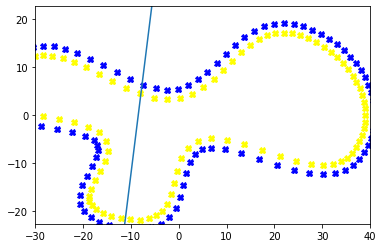

150, k=8.06554007474201, c=59.06788605228302


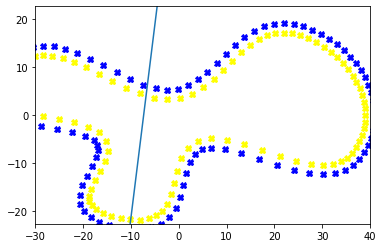

151, k=185.17940549768244, c=1673.8920648902613


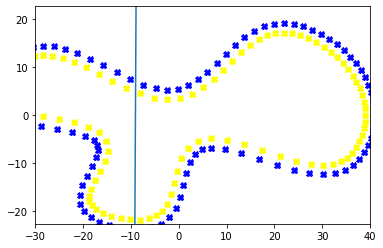

152, k=222.91189140520532, c=1768.4976506754724


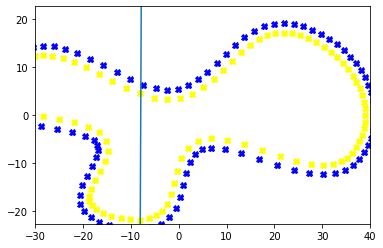

153, k=-6.517667627567763, c=-69.15692306901198


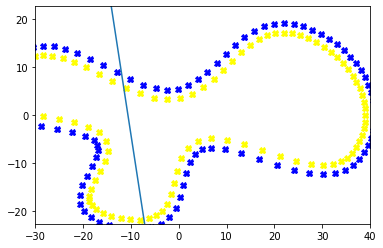

154, k=-6.430010134877426, c=-61.33044212062913


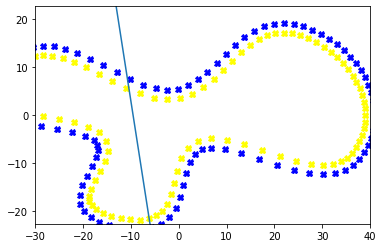

155, k=-2.5613221807372253, c=-35.685434770259874


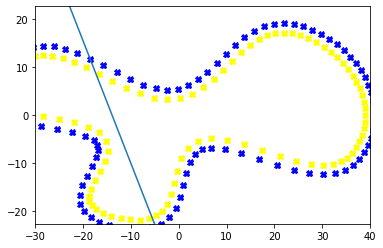

156, k=-2.5355780946043107, c=-32.57350931036485


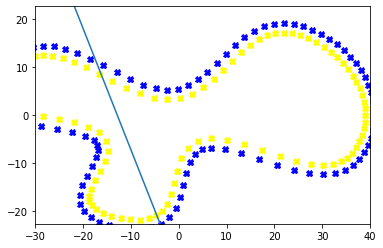

157, k=-1.2981485754686122, c=-26.006577764421905


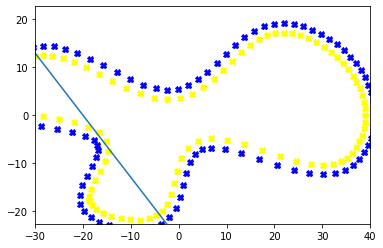

158, k=-1.2926212688789962, c=-24.18526675555097


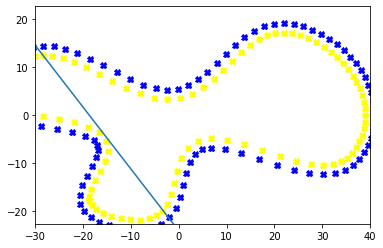

159, k=-0.7186043913949798, c=-21.52230526432773


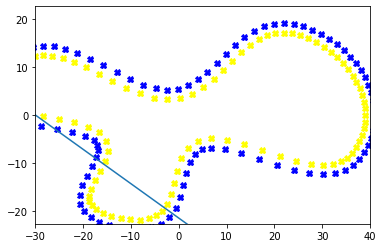

160, k=-0.7191795617669209, c=-20.100142951794332


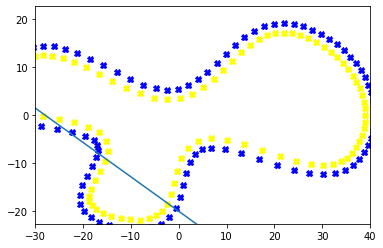

161, k=-0.41894854007686416, c=-18.490161396255736


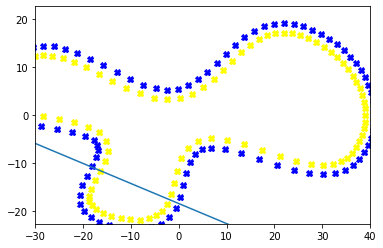

162, k=-0.4199813465768068, c=-17.14978701179608


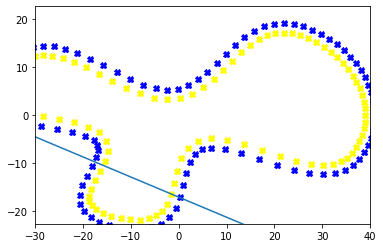

163, k=-0.2749924226283292, c=-15.77854257111488


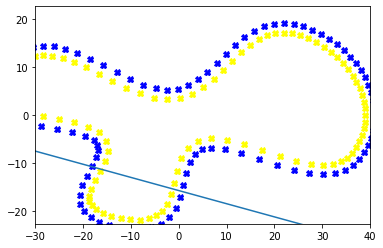

164, k=-0.2754389671422919, c=-14.42070306511718


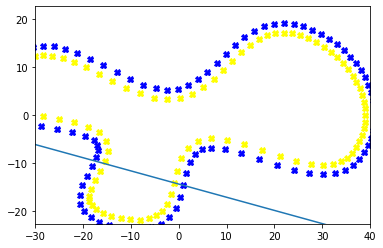

165, k=-0.24399014241605874, c=-13.04956114708929


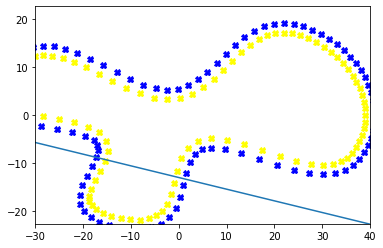

166, k=-0.24379896033427526, c=-11.703047004343889


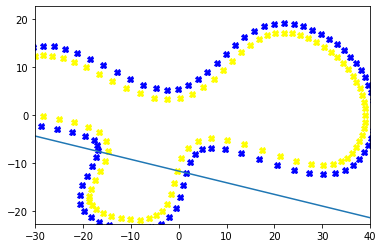

167, k=-0.3299700537376465, c=-10.394446139544105


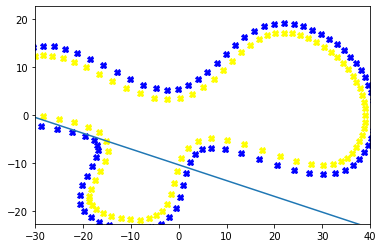

168, k=-0.33227417081230687, c=-8.979150719576786


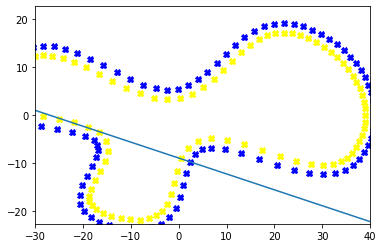

169, k=-0.6057395305387553, c=-7.437551872989758


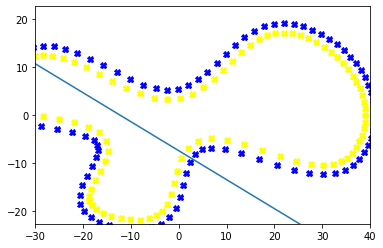

170, k=-0.6162155571965889, c=-5.886435655620548


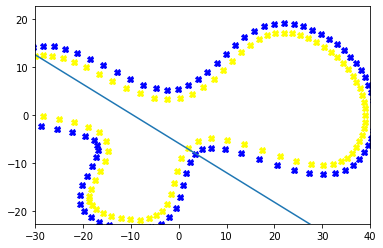

171, k=-1.3908132872524244, c=-2.366251647711727


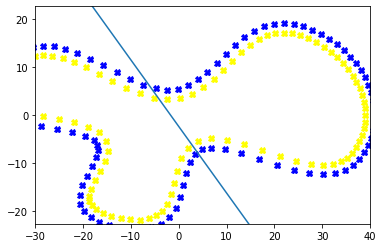

172, k=-1.4066249029024471, c=-0.055705644918896624


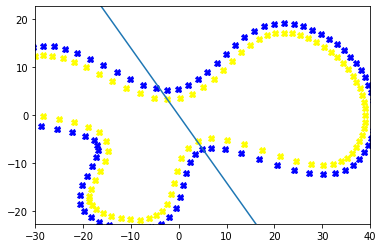

173, k=-5.311432344899837, c=22.819084589847133


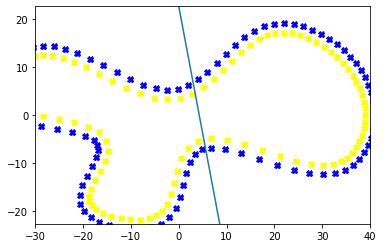

174, k=-5.219508504204508, c=29.841807494025698


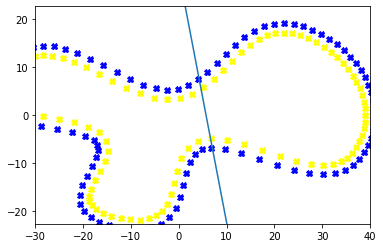

175, k=9.908729034772257, c=-87.60232516178105


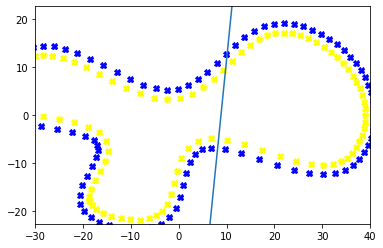

176, k=10.04440286470558, c=-105.1846024656576


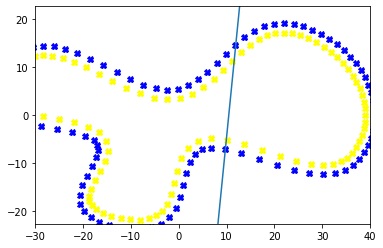

177, k=3.9074273820845784, c=-51.72874473804566


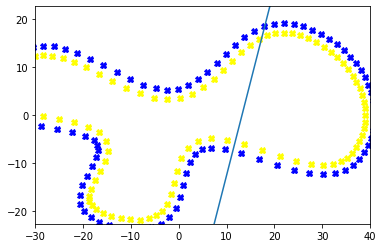

178, k=3.912363659989732, c=-59.28620757175808


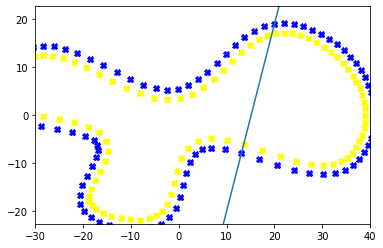

179, k=3.058384290602401, c=-54.14384543242172


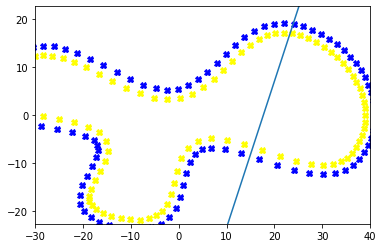

180, k=3.0590590556265393, c=-60.53675493472207


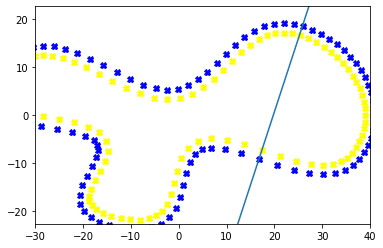

181, k=2.958237057561395, c=-64.9791750277418


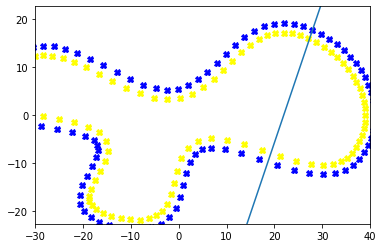

182, k=2.9579442077139304, c=-71.09485630897532


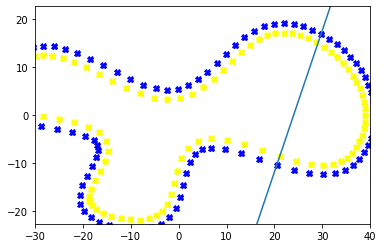

183, k=3.3359850755989138, c=-85.23988138656676


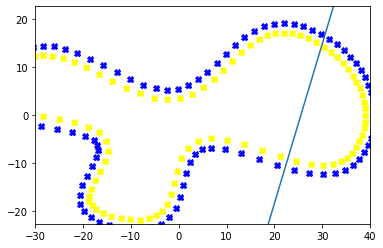

184, k=3.338186743641513, c=-91.76643248990109


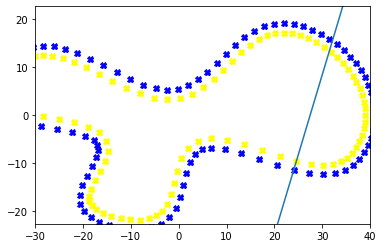

185, k=4.649130238839508, c=-131.04455132234654


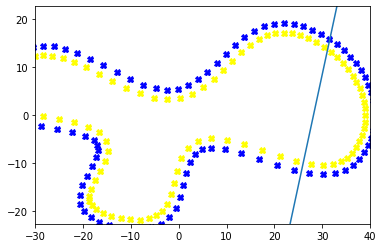

186, k=4.661299990661114, c=-139.25419949585532


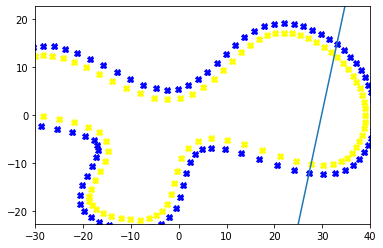

187, k=11.984823066174654, c=-355.7644325193628


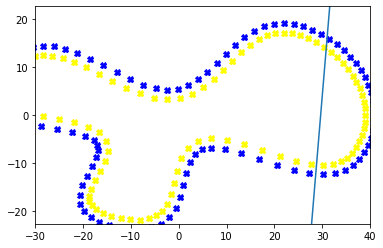

In [0]:
ax = np.linspace(-40, 40)
for i,(k,c) in enumerate(zip(path.ks,path.cs)):
    plt.figure()
    plt.plot(outer[:,0], outer[:,1], "X", color="blue")
    plt.plot(inner[:,0], inner[:,1], "X", color="yellow")
    print(f"{i}, k={k}, c={c}")
    plt.axis("equal")
    plt.xlim([-30,40])
    plt.ylim([-20,20])
    plt.plot(ax, ax*k + c)
    
    plt.show()
    #time.sleep(1)

In [0]:
np.array(path.ks[1:-1])-np.array(path.ks[0:-2])==0

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,

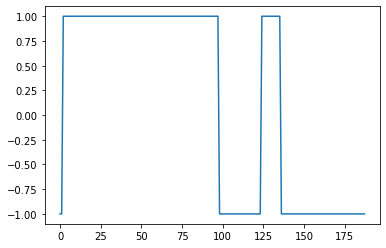

In [0]:
plt.figure()
plt.plot(np.array(path.direction_changes))
plt.show()

# ValueError: argmin of empty sequence

## Old version
    
    >>>path = PathPlanning(np.array([8,0]), clockwise=1)
    >>>bb = np.array([b_cones[0,:], b_cones[2,:]])
    >>>path.find_path(B=bb, Y=y_cones[:3,:], n_steps=10, verbose=True)


    Step 1 done!
    Step 2 done!
    Step 2 done!
    ---------------------------------------------------------------------------
    ValueError                                Traceback (most recent call last)
    <ipython-input-13-167a864afeae> in <module>()
        1 bb = np.array([b_cones[0,:], b_cones[2,:]])
        2 print(bb)
    ----> 3 path.find_path(B=bb, Y=y_cones[:3,:], n_steps=10, verbose=True)

    4 frames
    <__array_function__ internals> in argmin(*args, **kwargs)

    /usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py in _wrapfunc(obj, method, *args, **kwds)
        59 
        60     try:
    ---> 61         return bound(*args, **kwds)
        62     except TypeError:
        63         # A TypeError occurs if the object does have such a method in its

    ValueError: attempt to get argmin of an empty sequence

## New version
- this specific error was removed. 

In [25]:
path = PathPlanning(np.array([8,0]), clockwise=1)
bb = np.array([b_cones[0,:], b_cones[2,:]])
print(bb)
path.find_path(B=bb, Y=y_cones[:3,:], n_steps=10, verbose=True)

[[8.70967742 0.98951258]
 [8.42741935 3.7064609 ]]
Step 1 done!
Step 2 done!
Step 3 done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: UserWarning: Too many iteration!
